# QOSF Task 2

<font size="3.5"> 
This notebook has been written for the Quantum Open-Source Foundation Mentorship Program screening process.

The task is to implement a quantum circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability. 

Requirements:
- The circuit should consist only of CNOTs, RXs and RYs.
- Start from all parameters in parametric gates being equal to 0 or randomly chosen.
- Find the right set of parameters using gradient descent (or more advanced optimization methods).
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise.

Compare the results for different numbers of measurements: 1, 10, 100, 1000.

Bonus question: How to make sure you produce state  $|01\rangle$ + $|10\rangle$  and not any other combination of $|01\rangle$ + $e^{i\phi}|10\rangle$ (for example $|01\rangle$  -  $|10\rangle$)? 

<hr style="border-width:thin"> </hr>

Notebook pre-requisite installations (pip install): 
- qiskit 
- pylatexenc (for circuit display in mpl)
</font>

## Imports and backends

Import all necessary libraries:
- numpy for various mathematical functions
- matplotlib for plotting visualizations
- qiskit for implementing quantum circuit and simulation

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, IBMQ, Aer, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere, plot_histogram
from qiskit.aqua.components import optimizers
from qiskit.providers.aer.noise import NoiseModel

Define backend simulators and import noise model:

In [2]:
# Define Aer backend simulators
qasm_backend = Aer.get_backend('qasm_simulator')
statevector_backend = Aer.get_backend('statevector_simulator')

# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_valencia')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## Bell state visualisation

Initialise the desired |01> + |10> state explicitly and plot on Q-sphere for visualisation. $\frac{1}{\sqrt2}$ coefficients ensure that the state is normalised and has equal probability of measuring |01> and |10>.

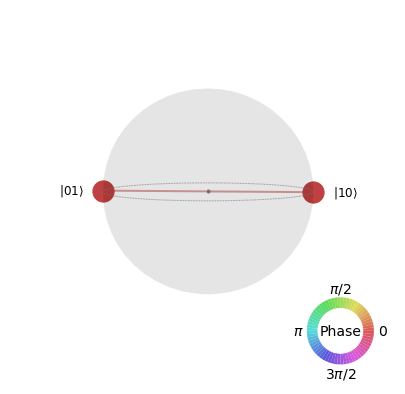

In [3]:
bell_coeffs = [0, 1/np.sqrt(2), 1/np.sqrt(2), 0]
bell_state = Statevector(bell_coeffs)
plot_state_qsphere(bell_state)

## Reference Bell creation circuit

Set up two-qubit quantum circuit:

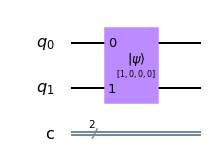

In [4]:
def initializeCircuit():
    '''
    Initialize a two-qubit circuit with |00> initial state.
    
    Returns
    -------
    circuit: QuantumCircuit
        Quantum circuit object that contains list of instructions bound to some registers
    
    q_reg: QuantumRegister
        Quantum register object to handle qubits in circuit
    
    c_reg: ClassicalRegister
        Classical register object to handle target bits in circuit
    
    '''
    
    #Qiskit initializes qubits to the |0> state by default, but here we initialise it explicitly
    initial_state = [1., 0., 0., 0.]
    
    #Define a two-qubit quantum register and two-bit classical register
    q_reg = QuantumRegister(2, 'q')
    c_reg = ClassicalRegister(2, 'c')
    
    #Define circuit with registers and initialize to the |00> state
    circuit = QuantumCircuit(q_reg, c_reg)
    circuit.initialize(initial_state, [q_reg[0], q_reg[1]])
    
    return circuit, q_reg, c_reg
    
initial_circ, q_reg, c_reg = initializeCircuit()
initial_circ.draw('mpl')

Build Bell state circuit using Hadamard and CNOT gates:

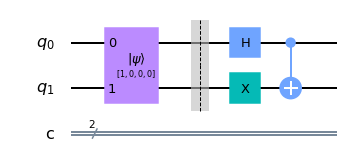

In [5]:
#Initialize |00> state
circ, q_reg, c_reg = initializeCircuit()

#Apply gates to transform to desired Bell state
circ.barrier()
circ.x(q_reg[1])
circ.h(q_reg[0])
circ.cx(q_reg[0],q_reg[1])

#Display circuit
circ.draw('mpl')

Plotting the final state on the Q-sphere before measurement to check that it is indeed the desired Bell state.

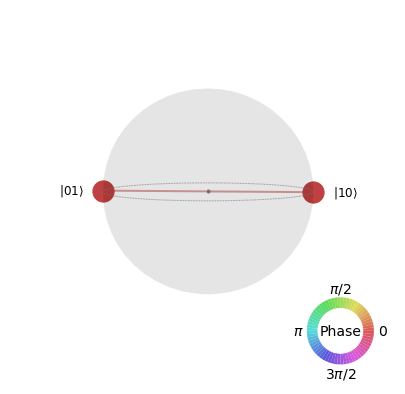

In [6]:
# Run circuit on statevector backend, obtain final state and plot on Q-sphere
final_state = execute(circ, statevector_backend).result().get_statevector()
plot_state_qsphere(final_state)

Measurement of the final state over 1000 iterations and results plotted on a histogram.

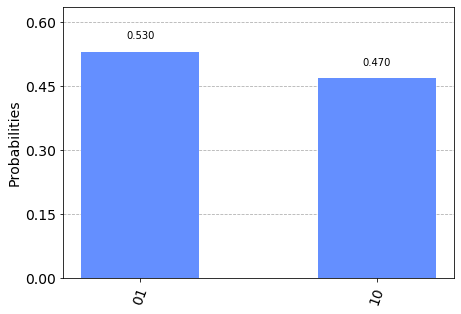

In [7]:
#Measure qubits
circ.barrier()
circ.measure(q_reg, c_reg)

#Run circuit on backend and output histogram
counts = execute(circ, qasm_backend, shots=1000).result().get_counts()
plot_histogram(counts)

## Hadamard gate decomposition

Circuit implemented that successfully returns the desired state, using the Hadamard gate. Now, in order to satisfy the requirements, we need to decompose the Hadamard gate into RX, RY gates only. We know that this is possible because the single-qubit and CNOT gates are universal.

The Hadamard gate acts on a single qubit and maps the basis state $|0\rangle$ to $\frac{|0\rangle + |1\rangle}{\sqrt{2}}$ and $|1\rangle$ to $\frac{|0\rangle - |1\rangle}{\sqrt{2}}$. Equivalently, this represents a rotation of $\pi$ about the axis $\frac{\hat{x}+\hat{z}}{\sqrt{2}}$ on the Bloch sphere.

Below is a Bloch sphere visualisation of the Hadamard gate acting on the $|0\rangle$ basis state to produce a superposition state:

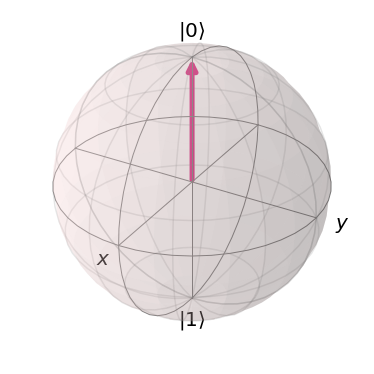

In [74]:
# Plot |0⟩ basis state on Bloch sphere
basis_0 = [0, 0, 1]
plot_bloch_vector(basis_0)

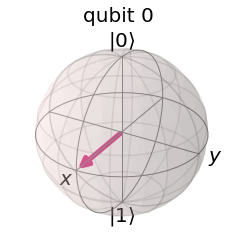

In [75]:
# Plot final state on Bloch sphere after Hadamard gate is applied to |0⟩ basis state
h_circ = QuantumCircuit(1,1)
h_circ.h(0)
final_state = execute(h_circ, statevector_backend).result().get_statevector()
plot_bloch_multivector(final_state)

By considering combinations of rotations on the Bloch sphere that achieve the same transformation as the Hadamard gate, we can decompose it into a combination of single qubit rotation gates.

Below, we first apply a rotation of $\pi$ about the $\hat{x}$ axis to the $|0\rangle$ basis state:

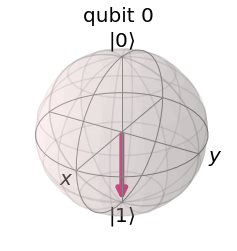

In [77]:
# Plot final state on Bloch sphere after RX gate with angle pi is applied to |0⟩ basis state
h_decomp_circ = QuantumCircuit(1,1)
h_decomp_circ.rx(np.pi, 0)
final_state = execute(h_decomp_circ, statevector_backend).result().get_statevector()
plot_bloch_multivector(final_state)

Next, a rotation of $-{\frac{\pi}{2}}$ about the $\hat{y}$ axis is applied:

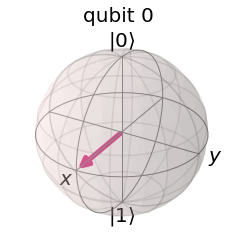

In [78]:
# Plot final state on Bloch sphere after RX gate with angle pi  
# and RY gate with angle -pi/2 are applied to |0⟩ basis state
h_decomp_circ.ry(-np.pi/2, 0)
final_state = execute(h_decomp_circ, statevector_backend).result().get_statevector()
plot_bloch_multivector(final_state)

This series of rotations seems to perform the same transformation to the basis state as the Hadamard gate (up to a global phase). We can verify that the state is the desired Bell state by creating a quantum circuit using the single-qubit rotation gates and measuring the final state over many iterations.

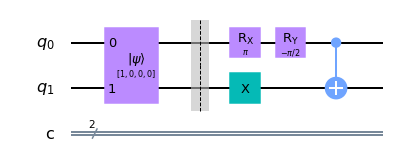

In [79]:
#Create Bell state using RX, RY and CNOT gates

#Initialize |00> state
circ, q_reg, c_reg = initializeCircuit()

#Apply gates to transform to desired Bell state
circ.barrier()
circ.x(q_reg[1])

#Decomposed H
circ.rx(np.pi, q_reg[0])
circ.ry(-np.pi/2, q_reg[0])

circ.cx(q_reg[0],q_reg[1])

#Display circuit
circ.draw('mpl')

Plotting the final state on the Q-sphere before measurement to check that it is indeed the desired Bell state.

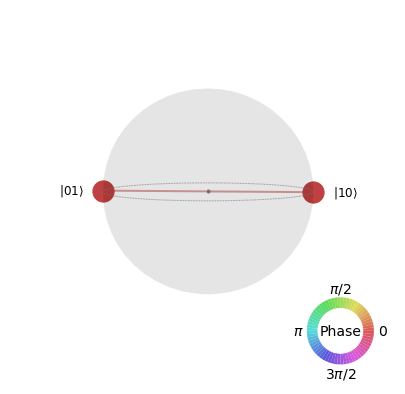

In [80]:
# Plot final state on Q-sphere after decomposed Bell producing circuit is applied to |00⟩ basis state
final_state = execute(circ, statevector_backend).result().get_statevector()
plot_state_qsphere(final_state)

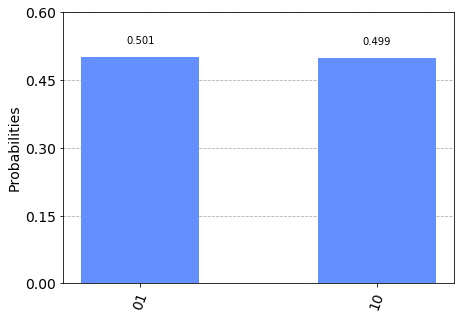

In [82]:
#Measure qubits
circ.barrier()
circ.measure(q_reg, c_reg)

#Run circuit on backend and output results
counts = execute(circ, qasm_backend, shots=1000).result().get_counts()
plot_histogram(counts)

Desired state successfully obtained using decomposed circuit.

Now we need to implement a parameter optimization method to parameterize the single-qubit gates. 

# Parameter optimization using Gradient Descent

PennyLane is a Python library that provides built-in optimizers such as gradient descent to optimize the parameters of quantum circuits. 

We will use it to directly construct the parameterized circuit and measure the probability of measuring each of the two-qubit states. We will then use the straightforward gradient descent optimizer to optimize the circuit paratemers.  

For the implementation of gradient descent we need to define a cost function that will guide the parameter optimization towards producing the desired resulting state probabilities. A common and simple such cost function is the mean squared error, which measures the difference between the estimator (circuit probabilities) and the estimated value (desired probability). This can be written in the following way for our current implementation:




$$
MSE = \frac{1}{4}(P_{00}^2 + (P_{01} - 0.5)^2 + (P_{10} - 0.5)^2 + P_{11}^2),
$$


where $P_{ij}$ is the probability of measuring the state $|ij\rangle$

## 1. Noiseless simulator

Using PennyLane to implement parameterised quantum circuit on noiseless backend, and defining the mean squared errror cost function:

In [119]:
# Import necessary packages 
import pennylane as qml

In [293]:
# Define noiseless backend using PennyLane default.qubit simulator
device = qml.device("default.qubit", wires=['q0', 'q1'], shots=1000, analytic=False)

# Define parameterized quantum circuit using QNode decorator
@qml.qnode(device)
def circuit(params):
    qml.RX(params[0], wires='q0')
    qml.RY(params[1], wires='q0')
    qml.PauliX(wires='q1')
    qml.CNOT(wires=['q0','q1'])
    
    return qml.probs(wires=['q0','q1'])

# Define mean squared error cost function 
def cost_func(params):
    return 0.25 * ((circuit(params)[0])**2 + 
                   (circuit(params)[1] - 0.5)**2 +
                   (circuit(params)[2] - 0.5)**2 +
                   (circuit(params)[3])**2)

Define the initial random parameters to optimize from, the gradient descent optimizer and the number of optimization steps:

In [294]:
# Initialize parameters using random values between 0 and 2pi
init_params = [np.random.uniform(0, 2*np.pi) for i in range(2)]

# Define gradient descent optimizer and set number of optimization steps
opt = qml.GradientDescentOptimizer(stepsize=0.5)

# Set the number of optimization steps
steps = 50

Perform gradient descent optimization of parameters using cost function and plot the evolution of the cost function at each iteration step:

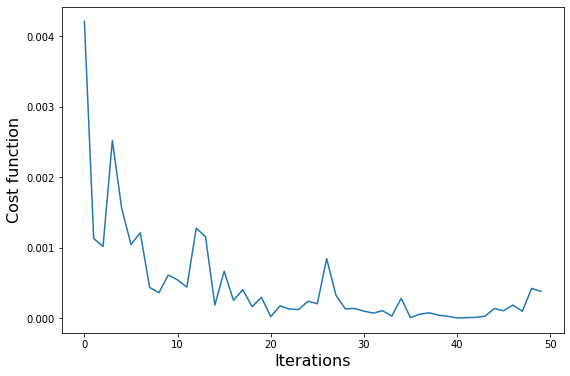

In [295]:
# Initialize parameters using same random values as noiseless
theta = init_params.copy()

# Evaluate cost function at each step
cost = []
for i in range(steps):
    theta = opt.step(cost_func, theta)
    cost.append(cost_func(theta))

# Plot figure of cost function vs. optimization iteration
plt.figure(figsize=(9,6))
plt.plot(cost)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Cost function', fontsize=16)
plt.show()

Optimized gate parameters:

In [296]:
print("Optimized angle for RX gate = {}".format(round(theta[0], 3)))
print("Optimized angle for RY gate = {}".format(round(theta[1], 3)))

Optimized angle for RX gate = 1.582
Optimized angle for RY gate = 3.866


Using the optimized gate parameters, measure the final state of the parameterised circuit over 1000 shots and plot the results in a histogram:

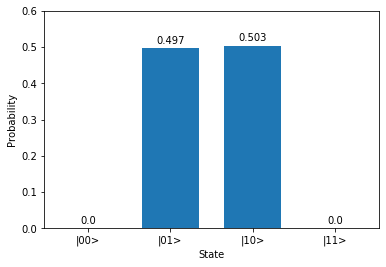

In [302]:
bins = ['|00>', '|01>', '|10>', '|11>']
probs = [round(i, 4) for i in circuit(theta)]

def autolabel(rects):
    '''
    Attach a text label above each bar displaying its probability.
    '''
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Plot histogram of results over 1000 measurement shots
fig, ax = plt.subplots()
rects = plt.bar(bins, probs, width=0.7)
autolabel(rects)
ax.set_ylabel('Probability')
ax.set_xlabel('State')
plt.ylim(0, 0.6)
plt.show()

The results suggest that a superposition state with equal probability of measuring state $|01\rangle$ and state $|10\rangle$ has been produced. This indicates that the gate parameters have been optimized successfully using gradient descent.

## 2. Noisy simulator

Now we perform the same parameter optimization, using a noisy backend. We vary the number of measurements to observe the effect of limited sampling on the results.

### a) 1 shot

In [217]:
# Set initial number of shots to 1
shots = 1

In [218]:
# Define backend using PennyLane qiskit.aer simulator with noise model from ibmq_valencia
device = qml.device("qiskit.aer", wires=['q0', 'q1'], shots=shots, 
                    basis_gates=basis_gates,
                    coupling_map=coupling_map,
                    noise_model=noise_model, 
                    analytic=False)

# Define parameterized quantum circuit using QNode decorator
@qml.qnode(device)
def circuit(params):
    qml.RX(params[0], wires='q0')
    qml.RY(params[1], wires='q0')
    qml.PauliX(wires='q1')
    qml.CNOT(wires=['q0','q1'])
    
    return qml.probs(wires=['q0','q1'])

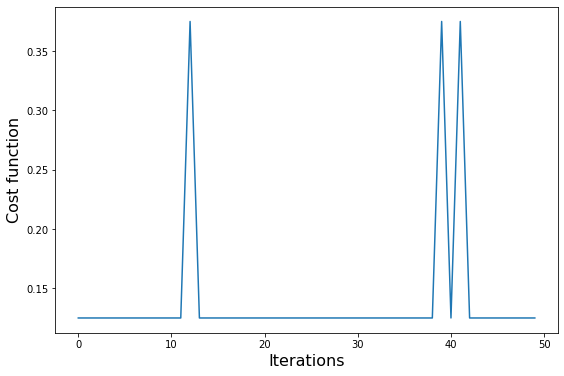

In [219]:
# Set the initial parameter values
theta = init_params.copy()

# Evaluate cost function at each step
cost = []
for i in range(steps):
    theta = opt.step(cost_func, theta)
    cost.append(cost_func(theta))

# Plot figure of cost function vs. optimization iteration
plt.figure(figsize=(9,6))
plt.plot(cost)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Cost function', fontsize=16)
plt.show()

Optimized gate parameters:

In [220]:
print("Optimized angle for RX gate = {}".format(round(theta[0], 3)))
print("Optimized angle for RY gate = {}".format(round(theta[1], 3)))

Optimized angle for RX gate = 2.486
Optimized angle for RY gate = 1.372


Plot histogram of probabilities of measuring different two-qubit states:

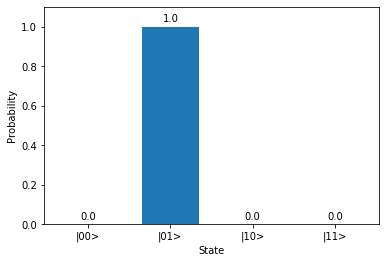

In [221]:
bins = ['|00>', '|01>', '|10>', '|11>']
probs = [i for i in circuit(theta)]

# Plot histogram of results over 1000 measurement shots
fig, ax = plt.subplots()
rects = plt.bar(bins, probs, width=0.7)
autolabel(rects)
ax.set_ylabel('Probability')
ax.set_xlabel('State')
plt.ylim(0, 1.1)
plt.show()

Clearly 1 shot isn't enough to demonstrate any meaningful results.

### b) 10 shots

In [201]:
# Set number of shots to 10
device.shots = 10

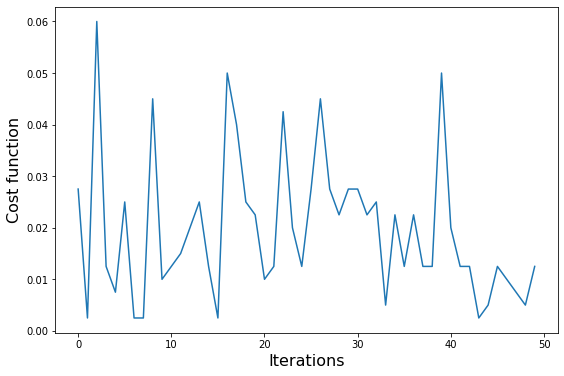

In [202]:
# Set the initial parameter values
theta = init_params.copy()

# Evaluate cost function at each step
cost = []
for i in range(steps):
    theta = opt.step(cost_func, theta)
    cost.append(cost_func(theta))

# Plot figure of cost function vs. optimization iteration
plt.figure(figsize=(9,6))
plt.plot(cost)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Cost function', fontsize=16)
plt.show()

Optimized gate parameters:

In [203]:
print("Optimized angle for RX gate = {}".format(round(theta[0], 3)))
print("Optimized angle for RY gate = {}".format(round(theta[1], 3)))

Optimized angle for RX gate = 2.044
Optimized angle for RY gate = 1.423


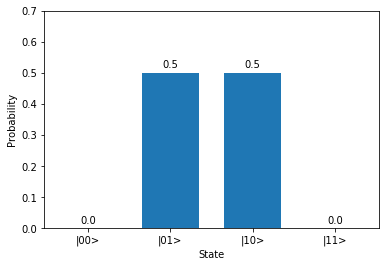

In [210]:
probs = [i for i in circuit(theta)]

# Plot histogram of results over 1000 measurement shots
fig, ax = plt.subplots()
rects = plt.bar(bins, probs, width=0.7)
autolabel(rects)
ax.set_ylabel('Probability')
ax.set_xlabel('State')
plt.ylim(0, 0.7)
plt.show()

Results suggest that the desired state has been produced, but not enough repeats for confidence. The cost function is still unstable and is not clearly minimized. 

### c) 100 shots

In [193]:
# Set number of shots to 100
device.shots = 100

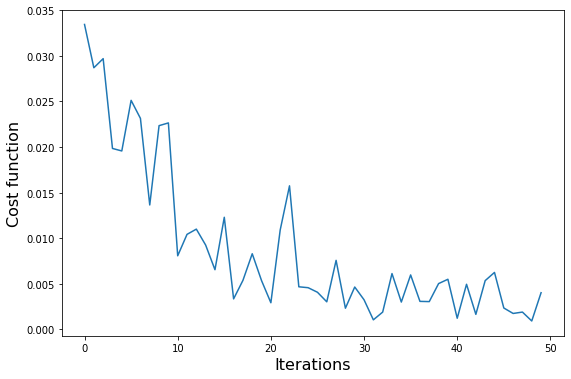

In [194]:
# Set the initial parameter values
theta = init_params.copy()

# Evaluate cost function at each step
cost = []
for i in range(steps):
    theta = opt.step(cost_func, theta)
    cost.append(cost_func(theta))

# Plot figure of cost function vs. optimization iteration
plt.figure(figsize=(9,6))
plt.plot(cost)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Cost function', fontsize=16)
plt.show()

Optimized gate parameters:

In [195]:
print("Optimized angle for RX gate = {}".format(round(theta[0], 3)))
print("Optimized angle for RY gate = {}".format(round(theta[1], 3)))

Optimized angle for RX gate = 2.029
Optimized angle for RY gate = 1.381


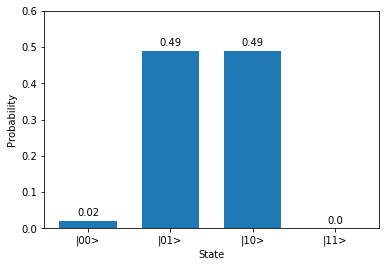

In [196]:
probs = [i for i in circuit(theta)]

# Plot histogram of results over 1000 measurement shots
fig, ax = plt.subplots()
rects = plt.bar(bins, probs, width=0.7)
autolabel(rects)
ax.set_ylabel('Probability')
ax.set_xlabel('State')
plt.ylim(0, 0.6)
plt.show()

Cost function is still noisy, but clear convergence can be seen. With higher number of shots and a noisy backend, the measurements of states not expected can be seen. However, we can conclude with relative confidence that the $|01\rangle$ and $|10\rangle$ states are produced with equal probability. 

### d) 1000 shots

In [222]:
# Set number of shots to 1000
device.shots = 1000

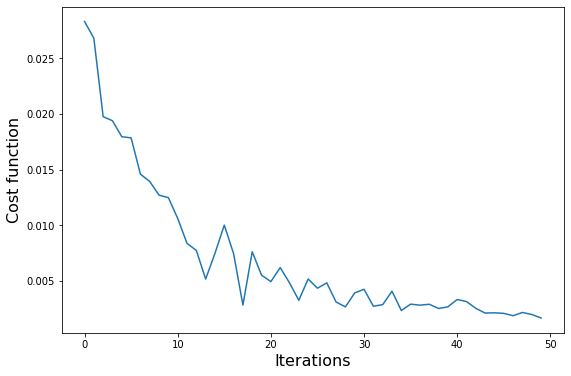

In [223]:
# Set the initial parameter values
theta = init_params.copy()

# Evaluate cost function at each step
cost = []
for i in range(steps):
    theta = opt.step(cost_func, theta)
    cost.append(cost_func(theta))

# Plot figure of cost function vs. optimization iteration
plt.figure(figsize=(9,6))
plt.plot(cost)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Cost function', fontsize=16)
plt.show()

Optimized gate parameters:

In [224]:
print("Optimized angle for RX gate = {}".format(round(theta[0], 3)))
print("Optimized angle for RY gate = {}".format(round(theta[1], 3)))

Optimized angle for RX gate = 2.038
Optimized angle for RY gate = 1.377


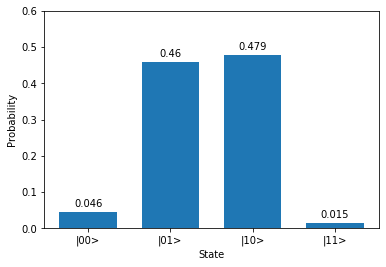

In [236]:
probs = [i for i in circuit(theta)]

# Plot histogram of results over 1000 measurement shots
fig, ax = plt.subplots()
rects = plt.bar(bins, probs, width=0.7)
autolabel(rects)
ax.set_ylabel('Probability')
ax.set_xlabel('State')
plt.ylim(0, 0.6)
plt.show()

The effect of noise on measurement is more apparent with more shots, as we can see a higher proportion of undesired states being measured. However, we now have higher confidence that the final produced state is the $|01 \rangle$ and $|10\rangle$ with equal probability. Furthermore, the cost function is less noisy and converges at a higher rate.

Increasing the number of shots has improved the convergence of the cost function, reduced the cost function noise, and indicated the presence of circuit noise from measurement of undesired states. It also increases the confidence of obtaining the desired equal probability state. 

# Bonus question

We need to determine whether the final state is indeed $|01\rangle$ + $|10\rangle$ and not another orthogonal state that measures to $|01\rangle$ and $|10\rangle$ in equal probability, such as $|01\rangle$ + $e^{i\phi}|10\rangle$ for any $\phi$.

This can be achieved by measuring the two qubits in the projective Bell basis rather than the computational basis. The Bell basis is a complete set of orthonormal states that are defined as follows:

$$
|\psi^{+}\rangle = \frac{1}{\sqrt 2}(|01\rangle + |10\rangle)
$$

$$
|\psi^{-}\rangle = \frac{1}{\sqrt 2}(|01\rangle - |10\rangle)
$$

$$
|\phi^{+}\rangle = \frac{1}{\sqrt 2}(|00\rangle + |11\rangle)
$$

$$
|\phi^{-}\rangle = \frac{1}{\sqrt 2}(|00\rangle - |11\rangle)
$$

To perform the Bell basis measurement, we simply unitarily transform from the Bell basis into the computational basis and then measure in the computational basis. This can be done using a CNOT gate and Hadamard gate, which is exactly the reverse of producing Bell pairs from the computational basis states. The mappings are as follows:

$$
|\psi^{+}\rangle → |01\rangle
$$

$$
|\psi^{-}\rangle → |11\rangle
$$

$$
|\phi^{+}\rangle → |00\rangle
$$

$$
|\phi^{-}\rangle → |10\rangle
$$


If we have the $|01\rangle + |10\rangle$ we expect to measure $|01\rangle$. If we have any other orthogonal state such as $|01\rangle - |10\rangle$ then the state will either be one of the other computational basis states or a superposition of them. Thus, we can confirm that we have the $|01\rangle + |10\rangle$ state by performing the basis change, measuring over many iterations, and seeing that we measure the state $|01\rangle$ with certainty (up to noise). 

We shall set up 3 initial states and perform the basis change procedure to demonstrate that we can determine with confidence whether the state is the desired $|01\rangle$ + $|10\rangle$ state.

In [289]:
# Set up  𝜓+ and 𝜓- initial states
psi_plus = [0, 1/np.sqrt(2), 1/np.sqrt(2), 0]
psi_minus = [0, 1/np.sqrt(2), -1/np.sqrt(2), 0]

# Set up |01⟩ + 𝑒xp(𝑖𝜙)|10⟩ initial state with random 𝜙
phi = np.random.uniform(0, 2*np.pi)
arbitrary_state = [0, 1/np.sqrt(2), (-1/np.sqrt(2))*np.exp(1.j*phi), 0]
print("𝜙:", phi)

𝜙: 5.085153518470838


## a) $\psi^{+}$ initial state

Quantum circuit initialised in $|01\rangle$ + $|10\rangle$ state and plotted on Q-sphere:

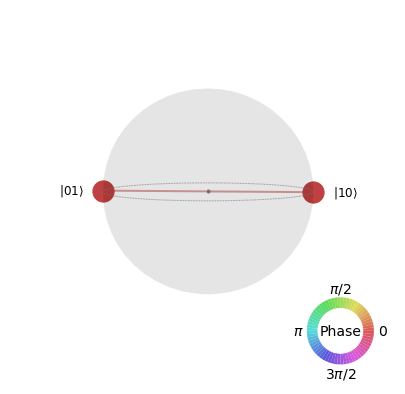

In [259]:
# Set up quantum circuit with 𝜓+ initial state
circ_plus = QuantumCircuit(2,2)
circ_plus.initialize(psi_plus, [0, 1])

# Plot 𝜓+ state on Q-sphere
final_state = execute(circ_plus, statevector_backend).result().get_statevector()
plot_state_qsphere(final_state)

Basis change circuit implemented and measured over 1000 shots:

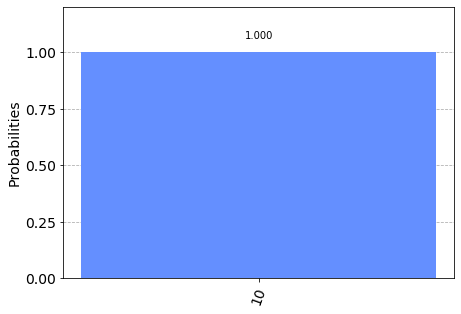

In [260]:
# Add reverse Bell production gates
circ_plus.cx(0,1)
circ_plus.h(0)
circ_plus.measure([0,1], [0,1])

#Run circuit on backend and output results
counts = execute(circ_plus, qasm_backend, shots=1000).result().get_counts()
plot_histogram(counts)

Note that the qubit ordering in Qiskit is reversed, so the desired $|01\rangle$ has been measured and we can confirm that the initial state was $|01\rangle + |10\rangle$.

## b) $\psi^{-}$ initial state

Quantum circuit initialised in $|01\rangle$ - $|10\rangle$ state and plotted on Q-sphere:

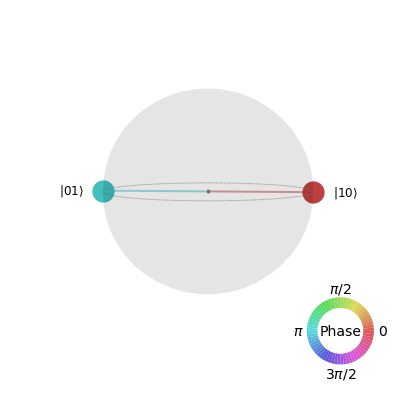

In [261]:
# Set up quantum circuit with 𝜓- initial state
circ_minus = QuantumCircuit(2,2)
circ_minus.initialize(psi_minus, [0, 1])

# Plot 𝜓- state on Q-sphere
final_state = execute(circ_minus, statevector_backend).result().get_statevector()
plot_state_qsphere(final_state)

Basis change circuit implemented and measured over 1000 shots:

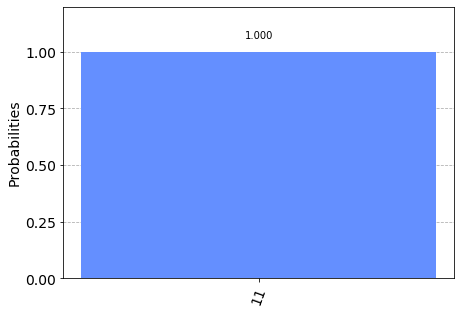

In [262]:
# Add reverse Bell production gates
circ_minus.cx(0,1)
circ_minus.h(0)
circ_minus.measure([0,1], [0,1])

#Run circuit on backend and output results
counts = execute(circ_minus, qasm_backend, shots=1000).result().get_counts()
plot_histogram(counts)

The state $|11\rangle$ has been measured, so we can confirm that the initial state was $|\psi^{-}\rangle$.

## c) $|01\rangle$ + $e^{i\phi}|10\rangle$ initial state

Quantum circuit initialised in $|01\rangle$ + $e^{i\phi}|10\rangle$ state where 𝜙 = 5.09, and plotted on Q-sphere:

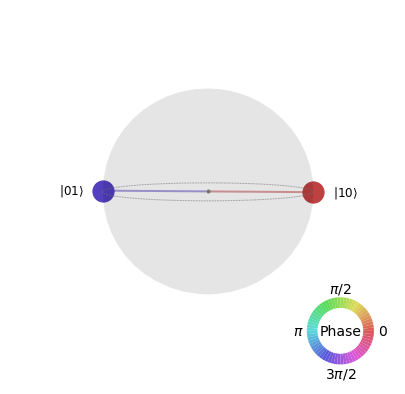

In [290]:
# Set up quantum circuit with arbitrary initial state
arb_circ = QuantumCircuit(2,2)
arb_circ.initialize(arbitrary_state, [0, 1])

# Plot arbitrary state on Q-sphere
final_state = execute(arb_circ, statevector_backend).result().get_statevector()
plot_state_qsphere(final_state)

Basis change circuit implemented and measured over 1000 shots:

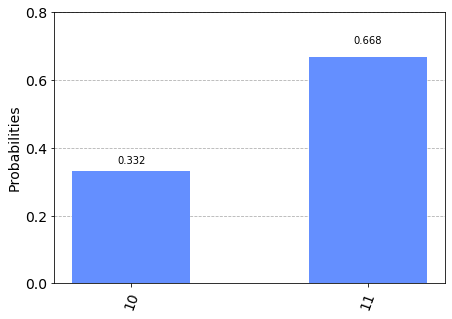

In [291]:
# Add reverse Bell production gates
arb_circ.cx(0,1)
arb_circ.h(0)
arb_circ.measure([0,1], [0,1])

#Run circuit on backend and output results
counts = execute(arb_circ, qasm_backend, shots=1000).result().get_counts()
plot_histogram(counts)

A superposition state between $|10\rangle$ and $|11\rangle$ has been measured, indicating that the initial state was not $|01\rangle$ + $|10\rangle$.